In [44]:
from typing import Callable
from collections import namedtuple
from copy import deepcopy as dc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from tqdm import tqdm

##### слои

###### линейный

In [45]:
LR = 0.0015
GAMMA = 0.9
BETA1 = 0.9
BETA2 = 0.999


class NNLinear:
    wb: np.ndarray
    inputs: np.ndarray
    optimizer_name: str

    nag_v: np.ndarray = None  # type: ignore
    adagrad_G: np.ndarray = None  # type: ignore
    adam_t: int = None  # type: ignore
    adam_m: np.ndarray = None  # type: ignore
    adam_v: np.ndarray = None  # type: ignore

    def __init__(self, in_len, out_len, optimizer_name, perceptron):
        self.wb = np.random.rand(in_len+1, out_len)-0.5
        self.optimizer_name = optimizer_name
        self.perceptron = perceptron

    def __repr__(self):
        return f'NNLinear({self.wb.shape})'

    def __eq__(self, o):
        return id(self) == id(o)

    def forward(self, inputs: np.ndarray):
        self.inputs = np.append(inputs, [1])
        return self.inputs @ self.wb

    def simple_forward(self, inputs: np.ndarray):
        return np.append(inputs, [1]) @ self.wb

    def simple_backward(self, grad):
        return (grad @ self.wb.T)[:-1]

    def backward(self, grad):
        grad_to_ret = (grad @ self.wb.T)[:-1]
        grad_wb = np.reshape(self.inputs, (-1, 1)) @ np.reshape(grad, (1, -1))
        if np.linalg.norm(grad_wb) != 0:
            grad_wb = grad_wb/np.linalg.norm(grad_wb)

        d = list()
        match self.optimizer_name:
            case 'SGD':
                d = grad_wb  # type:ignore

                if np.linalg.norm(d) > 0.001:
                    d = LR * d / np.linalg.norm(d)

            case 'NAG':
                # если это наш первый шаг
                if self.nag_v is None:
                    self.nag_v = np.zeros(grad_wb.shape)

                # что тут происходит???
                # мы хотим посчитать градиент функции в точке self.wb - gamma * self.nag_v
                # сдвинем веса в эту точку и вызовем специальную функцию от перцептрона
                # она прогонит self.inputs от текущего слоя сети до последнего,
                # посчитает лосс
                # и прогонит градиент по всем слоям от последнего вплоть до текущего (невключительно)
                # потом мы посчитаем градиент относительно слоев, тем самым найдем
                #           градиент функции в точке self.wb - gamma * self.nag_v
                # а потом надо веса сдвинуть обратно

                # ищем градиент в точке now - gamma*v_old
                self.wb -= GAMMA*self.nag_v  # type:ignore
                j = self.perceptron.fit_special_layer_get_my_grad(
                    self, self.inputs[:-1])
                J = np.reshape(self.inputs, (-1, 1)) @ np.reshape(j, (1, -1))
                # возвращаем веса
                self.wb += GAMMA*self.nag_v  # type:ignore

                # вычисляем сдвиг
                self.nag_v = GAMMA*self.nag_v + LR*J  # type:ignore
                d = self.nag_v

                if np.linalg.norm(d) > 0.001:
                    d = LR * d / np.linalg.norm(d)

            case 'Adagrad':
                if self.adagrad_G is None:
                    self.adagrad_G = np.zeros(self.wb.shape)
                self.adagrad_G += grad_wb**2
                d = 1/np.sqrt(self.adagrad_G+10e-6)*grad_wb  # type:ignore

                if np.linalg.norm(d) > 0.001:
                    d = LR * d / np.linalg.norm(d)

            case 'Adam':
                if self.adam_t is None:
                    self.adam_t = 0
                    self.adam_m = np.zeros(self.wb.shape)
                    self.adam_v = np.zeros(self.wb.shape)
                self.adam_t += 1
                self.adam_m = BETA1*self.adam_m + \
                    (1-BETA1)*grad_wb    # type:ignore
                self.adam_v = BETA2*self.adam_v + \
                    (1-BETA2)*grad_wb**2  # type:ignore
                m = self.adam_m/(1-BETA1**self.adam_t)  # type:ignore
                v = self.adam_v/(1-BETA2**self.adam_t)  # type:ignore
                d = m/np.sqrt(v + 10e-8)  # type:ignore

                if np.linalg.norm(d) > 0.001:
                    d = LR * d / np.linalg.norm(d)

            case _:
                raise RuntimeError('unknown optimizing method')

        self.wb -= d

        return grad_to_ret

###### функции

In [46]:
relu = np.vectorize(lambda x: x if x > 0 else 0)
der_relu = np.vectorize(lambda x: 1 if x > 0 else 0)


class NNRelu:
    inputs: np.array

    def forward(self, inputs):
        self.inputs = inputs
        return relu(inputs)

    def backward(self, grad):
        res = grad * der_relu(self.inputs)
        return res


def sigmoid(x): return 1/(1+np.exp(-x))
def der_sigmoid(x): return sigmoid(x)*(1-sigmoid(x))


class NNSigmoid:
    inputs: np.array

    def forward(self, inputs):
        self.inputs = inputs
        return sigmoid(inputs)

    def backward(self, grad):
        res = grad * der_sigmoid(self.inputs)
        return res

In [47]:
def softmax(x):
    if np.linalg.norm(x) < 0.001:
        return np.zeros(len(x))
    x = x / np.linalg.norm(x)
    return np.exp(x)/(np.exp(x)).sum() if (np.exp(x)).sum() > 0.01 else np.zeros(len(x))


class NNSoftmax:
    inputs: np.array

    def forward(self, inputs):
        self.inputs = inputs
        return softmax(inputs)

    def backward(self, grad):
        res = grad * softmax(self.inputs)*(1-softmax(self.inputs))
        return res

###### лосс

In [48]:
LossFunc = namedtuple('LossFunc', ['f', 'df', 'name'])

In [49]:
def mse(x, y): return sum((x-y)**2)/len(x)
def der_mse(x, y): return (x-y)*2/len(x)*-1


MSE = LossFunc(mse, der_mse, 'MSE LOSS')

In [50]:
def cross_entropy(target, pred):
    pred = np.clip(pred, 1e-15, 1 - 1e-15)
    return -sum(target * np.log(pred) - (1 - target) * np.log(1 - pred))


def der_cross_entropy(target, pred):
    pred = np.clip(pred, 1e-15, 1 - 1e-15)
    return - (target / pred) + (1 - target) / (1 - pred)


CrossEntropy = LossFunc(cross_entropy, der_cross_entropy, 'Cross Entropy LOSS')

###### модель

In [51]:
class Perceptron:
    layers: list
    loss: LossFunc
    last_target: np.ndarray | None

    def __init__(self, sizes: list[int], loss, optimizer):
        self.layers = [
            x for i, o in zip(sizes, sizes[1:]+[10]) for x in [NNLinear(i, o, optimizer, self), NNSigmoid()]
        ] + [NNSoftmax()]
        self.loss = loss

    def forward(self, inputs):
        res = inputs
        for layer in self.layers:
            res = layer.forward(res)
        return res

    def backward(self, target, pred):
        grad_by_last_layer_outs = self.loss.df(target, pred)
        grad = grad_by_last_layer_outs
        for layer in self.layers[::-1]:
            grad = layer.backward(grad)

    def fit(self, x, y):
        self.last_target = y
        pred = self.forward(x)
        self.backward(y, pred)
        return np.argmax(pred)

    def predict(self, x, y):
        pred = self.forward(x)
        return np.argmax(pred)

    def calc_for_special_layer(self, layer: NNLinear, inputs: np.ndarray):
        index = self.layers.index(layer)
        res = inputs
        for layer in self.layers[index:]:
            res = layer.forward(res) if type(
                layer) != NNLinear else layer.simple_forward(res)
        return self.loss.f(self.last_target, res)

    def fit_special_layer_get_my_grad(self, layer: NNLinear, inputs: np.ndarray):
        index = self.layers.index(layer)
        res = inputs
        for layer in self.layers[index:]:
            res = layer.forward(res) if type(
                layer) != NNLinear else layer.simple_forward(res)
        grad_by_last_layer_outs = self.loss.df(self.last_target, res)
        grad = grad_by_last_layer_outs
        for layer in self.layers[index+1:][::-1]:
            grad = layer.backward(grad) if type(
                layer) != NNLinear else layer.simple_backward(grad)
        return grad

###### данные

In [59]:
ds = datasets.MNIST(
    root='data',
    train=True,
    download=True,

    transform=lambda img: np.array(np.asarray(img).flatten())/256,
    target_transform=lambda x: np.array(
        [1 if i == x else 0 for i in range(10)])
)
dl = {
    'test': DataLoader(Subset(ds, range(0, 100)), shuffle=True, batch_size=None),
    'train': DataLoader(Subset(ds, range(70, 110)), shuffle=True, batch_size=None),
}

##### Тренируем

###### функции тренировки

In [60]:
def run_epoch(model, train=False):
    results = 0
    d = dl['train'] if train else dl['test']
    for X, y in d:
        X, y = np.array(X), np.array(y)
        if train:
            pred = model.fit(X, y)
        else:
            pred = model.predict(X, y)
        results += (np.argmax(y) == pred)
    return results/len(d)


def train_many_epochs(model, N):
    global LR
    train_ac = []
    test_ac = []

    for i in tqdm(range(N)):
        if i == 30:
            LR = LR*0.65
        a = run_epoch(model, True)
        b = run_epoch(model, False)
        # print(a, b)
        train_ac.append(a)
        test_ac.append(b)

    plt.plot(range(1, N+1), train_ac, label='train')
    plt.plot(range(1, N+1), test_ac, label='test')
    plt.legend()
    plt.show()
    return train_ac

###### тренировка

In [78]:
SGD = 'SGD'
NAG = 'NAG'
ADAGRAD = 'Adagrad'
ADAM = 'Adam'


def demo(optim: str, epochs: int = 20, samples: int = 500):
    global LR, GAMMA, BETA1, BETA2, dl

    match optim:
        case 'SGD':
            LR = 0.065
        case 'NAG':
            LR = 0.0065
            GAMMA = 0.95
        case 'Adagrad':
            LR = 0.015
        case 'Adam':
            LR = 0.0065
            GAMMA = 0.9
            BETA1 = 0.9
            BETA2 = 0.99

    dl = {
        'test': DataLoader(Subset(ds, range(0, samples)), shuffle=True, batch_size=None),
        'train': DataLoader(Subset(ds, range(int(samples*0.7), int(samples*1.05))), shuffle=True, batch_size=None),
    }

    p = Perceptron(
        [784] + [128, 128] + [10],
        CrossEntropy,
        optim
    )
    print(f'optimiser is {optim}')
    train_many_epochs(p, epochs)

optimiser is SGD


100%|██████████| 50/50 [01:15<00:00,  1.50s/it]


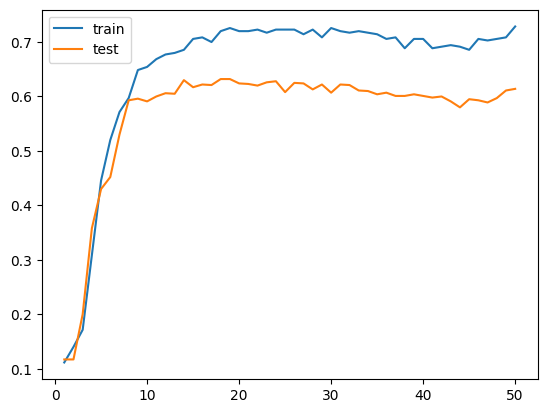

In [69]:
demo(SGD, samples=1000, epochs=50)

optimiser is NAG


100%|██████████| 50/50 [02:01<00:00,  2.43s/it]


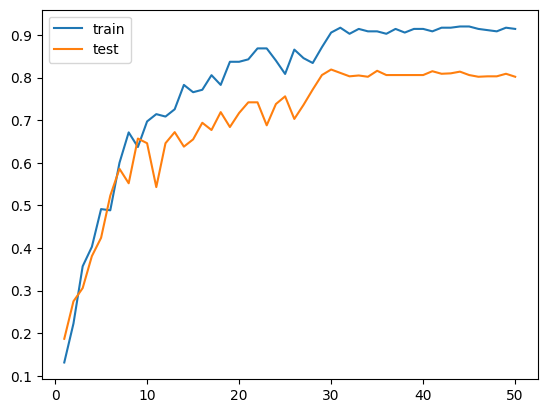

In [76]:
demo(NAG, samples=1000, epochs=50)

optimiser is Adagrad


100%|██████████| 50/50 [01:41<00:00,  2.03s/it]


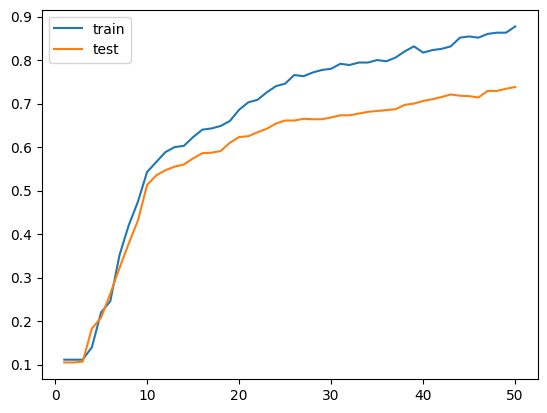

In [79]:
demo(ADAGRAD, samples=1000, epochs=50)

optimiser is Adam


100%|██████████| 50/50 [02:11<00:00,  2.63s/it]


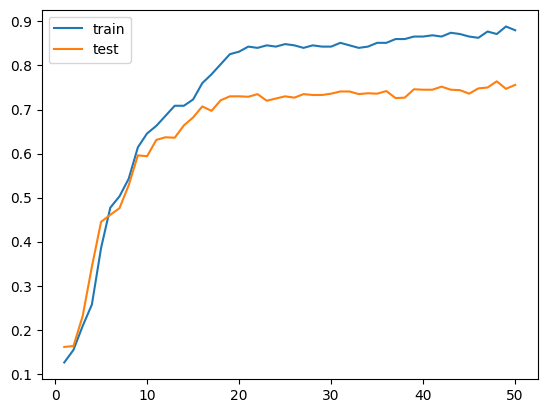

In [74]:
res = demo(ADAM, samples=1000, epochs=50)